In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

train_data = np.load('k49-train-imgs.npz')['arr_0']
train_labels = np.load('k49-train-labels.npz')['arr_0']
test_data = np.load('k49-test-imgs.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']

train_data1 = tf.keras.utils.normalize(train_data, axis=1)
test_data1 = tf.keras.utils.normalize(test_data, axis=1)

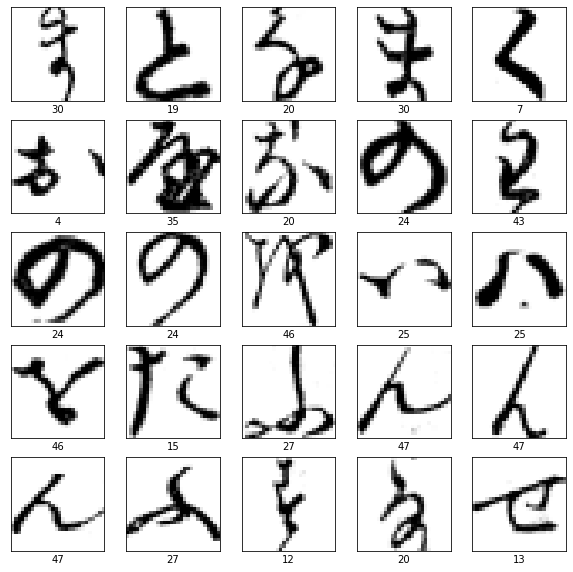

In [2]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
train_data = train_data1.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
test_data = test_data1.reshape((test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

#outlining number of validation samples (picked 8% of training data)
num_validation_samples = 0.08 * train_data.shape[0]
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

#isolating test samples
num_test_samples = test_data.shape[0]
num_test_samples = tf.cast(num_test_samples, tf.int64)

#setting buffer size and shuffling training data
BUFFER_SIZE = 10000
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#extracting validation data from grouping into own var
validation_dataset = train_dataset.take(num_validation_samples)
#excluding validation data from grouping and defining as training data
train_dataset = train_dataset.skip(num_validation_samples)

#setting batch size
BATCH_SIZE = 128
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(num_validation_samples)
test_dataset = test_dataset.batch(num_test_samples)

#separating validation data into inputs and targets
validation_inputs, validation_targets = next(iter(validation_dataset))

In [4]:
input_size = 784
output_size = 49
standard_hidden_layer_width = 512
NUM_EPOCHS = 100
VALIDATION_STEPS = num_validation_samples // BATCH_SIZE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                            tf.keras.layers.MaxPooling2D(2, 2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(standard_hidden_layer_width, activation='relu'),
                            tf.keras.layers.Dense(output_size, activation='softmax')
                            ])

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_dataset, epochs=NUM_EPOCHS, callbacks=[reduce_lr], validation_data=(validation_inputs, validation_targets), validation_steps=VALIDATION_STEPS, verbose=1)

Train for 1671 steps, validate on 18589 samples
Epoch 1/100
1671/1671 [==============================] - 163s 98ms/step - loss: 0.6321 - accuracy: 0.8310 - val_loss: 0.2672 - val_accuracy: 0.9257
Epoch 2/100
1671/1671 [==============================] - 162s 97ms/step - loss: 0.2518 - accuracy: 0.9290 - val_loss: 0.1946 - val_accuracy: 0.9454
Epoch 3/100
1671/1671 [==============================] - 166s 99ms/step - loss: 0.1820 - accuracy: 0.9475 - val_loss: 0.1655 - val_accuracy: 0.9529
Epoch 4/100
1671/1671 [==============================] - 166s 99ms/step - loss: 0.1433 - accuracy: 0.9578 - val_loss: 0.1397 - val_accuracy: 0.9599
Epoch 5/100
1671/1671 [==============================] - 166s 99ms/step - loss: 0.1160 - accuracy: 0.9649 - val_loss: 0.1258 - val_accuracy: 0.9637
Epoch 6/100
1671/1671 [==============================] - 167s 100ms/step - loss: 0.0977 - accuracy: 0.9698 - val_loss: 0.1251 - val_accuracy: 0.9636
Epoch 7/100
1671/1671 [==============================] - 163s 9

In [5]:
model.save('k49-convnet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: k49-convnet\assets


In [6]:
complete_model = tf.keras.models.load_model('k49-convnet')

In [7]:
predictions = complete_model.predict([test_data])

In [51]:
totals = []
for cls in range(49):
    total = 0
    for i in test_labels:
        if i == cls:
            total = total + 1
    totals.append(total)

hits = []
for cls in range(49):
    total_hits = 0
    for i in range(0,test_labels.shape[0]):
        if test_labels[i] == cls == np.argmax(predictions[i]):
            total_hits = total_hits + 1
    hits.append(total_hits)
    
accuracy_list = []
for i in range(0,len(hits)):
    accuracy = hits[i]/totals[i]
    accuracy_list.append(accuracy)

print(np.mean(accuracy_list))

[1000, 1000, 1000, 126, 1000, 1000, 1000, 1000, 767, 1000, 1000, 1000, 1000, 678, 629, 1000, 418, 1000, 1000, 1000, 1000, 1000, 336, 399, 1000, 1000, 836, 1000, 1000, 324, 1000, 498, 280, 552, 1000, 1000, 260, 1000, 1000, 1000, 1000, 1000, 348, 390, 68, 64, 1000, 1000, 574]
[960, 970, 971, 113, 957, 889, 931, 929, 722, 926, 954, 921, 909, 593, 562, 963, 405, 959, 933, 945, 909, 941, 315, 364, 934, 931, 799, 910, 945, 294, 967, 466, 249, 528, 970, 948, 246, 980, 918, 927, 928, 968, 331, 354, 50, 58, 964, 978, 474]
0.930142277358246
